<a href="https://colab.research.google.com/github/abhinav-exp/Forecasting-CryptoCurrency-Prices/blob/master/TFLANN_with_TAO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
GitHubDataLink = 'https://raw.githubusercontent.com/abhinav-exp/Forecasting-CryptoCurrency-Prices/master/Datasets/'
InputFileLink = GitHubDataLink + 'DataBTC2017.csv'
data1 = pd.read_csv(InputFileLink, header=0, index_col=0)
print(data1)

            CBBTCUSD
DATE                
2017-06-18   2515.25
2017-06-19   2596.98
2017-06-20   2725.08
2017-06-21   2643.35
2017-06-22   2679.99
...              ...
2019-08-03  10820.75
2019-08-04  10997.82
2019-08-05  11775.14
2019-08-06  11440.08
2019-08-07  12014.41

[781 rows x 1 columns]


In [ ]:
data1min = data1.min()
data1max = data1.max()

normalize = lambda x: (x - data1min + 1)/(data1max - data1min + 2)
data2 = normalize(data1)
print(data2)

            CBBTCUSD
DATE                
2017-06-18  0.034073
2017-06-19  0.038680
2017-06-20  0.045901
2017-06-21  0.041294
2017-06-22  0.043360
...              ...
2019-08-03  0.502247
2019-08-04  0.512228
2019-08-05  0.556045
2019-08-06  0.537158
2019-08-07  0.569532

[781 rows x 1 columns]


In [ ]:
def split_sequence(sequence, n_steps):
  X= list()
  for i in range(len(sequence) - n_steps):
    end_ix = i + n_steps
    seq_x= sequence.values[i:end_ix, 0]
    X.append(seq_x) 
  return pd.DataFrame(X)

data3 = split_sequence(data2, 10)
print(data3.shape)
print(data3)

(771, 10)
            0         1         2         3         4         5         6  \
0    0.034073  0.038680  0.045901  0.041294  0.043360  0.043967  0.037432   
1    0.038680  0.045901  0.041294  0.043360  0.043967  0.037432  0.033530   
2    0.045901  0.041294  0.043360  0.043967  0.037432  0.033530  0.028023   
3    0.041294  0.043360  0.043967  0.037432  0.033530  0.028023  0.037484   
4    0.043360  0.043967  0.037432  0.033530  0.028023  0.037484  0.036208   
..        ...       ...       ...       ...       ...       ...       ...   
766  0.441959  0.449255  0.447073  0.426045  0.430599  0.427984  0.432307   
767  0.449255  0.447073  0.426045  0.430599  0.427984  0.432307  0.461562   
768  0.447073  0.426045  0.430599  0.427984  0.432307  0.461562  0.479501   
769  0.426045  0.430599  0.427984  0.432307  0.461562  0.479501  0.486030   
770  0.430599  0.427984  0.432307  0.461562  0.479501  0.486030  0.502247   

            7         8         9  
0    0.033530  0.028023  0.03

In [ ]:
train_x = data3.iloc[:int(0.85*len(data2)), :9]
train_y = data3.iloc[:int(0.85*len(data2)), 9:10]
test_x = data3.iloc[int(0.85*len(data2)):, :9]
test_y = data3.iloc[int(0.85*len(data2)):, 9:10]
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(663, 9)
(663, 1)
(108, 9)
(108, 1)


In [ ]:
class TFLANN():
  def __init__(self, W):
    self.weight_matrix = W
  
  def func_x(x):
    const_x = np.ones((len(x), 1))
    orginal_x = x
    sinned_x = np.sin(np.pi*x)
    cossed_x = np.cos(np.pi*x)
    functioned_x = np.hstack((x, sinned_x, cossed_x, const_x))
    return functioned_x

  def forward_propagation(x):
    funced_x = TFLANN.func_x(x)
    return (np.tanh(np.dot(funced_x, self.weight_matrix)) + 1)/2

In [ ]:
find_mse = lambda x , y: np.mean(abs(x - y))

In [284]:
class TAO():
  def __init__(self, p_size):
    self.p_size = p_size
    self.train_py = np.tile(train_y, (1, p_size)).T
    self.weights = 2*np.random.random((self.p_size, 9*3 + 1)) - 1
    self.objectives = self.forward_propagation(self.weights)
    self.supervisor = np.argmin(self.objectives)

  def func_x(self, x):
    const_x = np.ones((len(x), 1))
    sinned_x = np.sin(np.pi*x)
    cossed_x = np.cos(np.pi*x)
    functioned_x = np.hstack((x, sinned_x, cossed_x, const_x))
    return functioned_x

  def forward_function(self, new_weights, x):
    return np.tanh(np.dot(new_weights , self.func_x(x).T))

  def forward_propagation(self, new_weights):
    predictions = self.forward_function(new_weights, train_x)
    errors = (predictions - self.train_py)
    return np.expand_dims(np.mean(errors ** 2, axis = 1), axis = 0)

  def update_weights_and_objectives(self, new_weights, new_obj):
    cond = (new_obj < self.objectives)
    self.weights = np.where(np.tile(cond.T, (1, 9*3 + 1)), new_weights, self.weights)
    self.objectives = np.where(cond, new_obj, self.objectives)
    self.supervisor = np.argmin(self.objectives)
  
  def optimise(self, gen):
    for _ in range(gen):
      print("gen "+str(_))

      # supervisor guidance
      r = np.tile(np.random.random((self.p_size, 1)), (1, 9*3 + 1))
      I = np.round_(r)
      S = self.weights[self.supervisor]
      new_w = self.weights + r * (S - I * self.weights)
      new_obj = self.forward_propagation(new_w)
      self.update_weights_and_objectives(new_w, new_obj)
      print(self.objectives[0, self.supervisor])
      # print(self.weights)

      #information sharing
      cmp_better = self.objectives.T >= self.objectives
      cnt_better = cmp_better.sum(axis = 1)
      # print(cmp_better)
      cmp_better = np.tile(np.expand_dims(cmp_better, axis = 2), (1, 1, 9*3 + 1))
      cnt_better = np.tile(np.expand_dims(cnt_better, axis = 1), (1, 9*3 + 1))
      S = np.tile(np.expand_dims(self.weights, axis = 0), (self.p_size, 1, 1))
      S = np.where(cmp_better, S, np.zeros(S.shape))
      S = S.sum(axis = 1)/cnt_better
      S_obj = self.forward_propagation(S)

      r = np.tile(np.random.random((self.p_size, 1)), (1, 9*3 + 1))
      I = np.round_(r)
      new_w = self.weights + r * (S - I * self.weights) * np.tile(np.sign(self.objectives - S_obj), (9*3 + 1, 1)).T
      new_obj = self.forward_propagation(new_w)
      self.update_weights_and_objectives(new_w, new_obj)

      #individual activity
      r = np.tile(np.random.random((self.p_size, 1)), (1, 9*3 + 1))
      new_w = self.weights + (-1*0.01 + r * 0.02)*self.weights
      new_obj = self.forward_propagation(new_w)
      self.update_weights_and_objectives(new_w, new_obj)


In [286]:
optimiser = TAO(50)
optimiser.optimise(1000)

gen 0
0.025416973455187026
gen 1
0.01042245318693417
gen 2
0.007295344113194283
gen 3
0.00643911326091954
gen 4
0.006400209952077721
gen 5
0.006386660762659932
gen 6
0.006372873655953736
gen 7
0.0063625802996016044
gen 8
0.00636123507286851
gen 9
0.0063611576171972205
gen 10
0.006361110274201227
gen 11
0.0063611086672802465
gen 12
0.0063611086672802465
gen 13
0.0063611086672802465
gen 14
0.006361108391796708
gen 15
0.006361107677469418
gen 16
0.006361107677445535
gen 17
0.006361107677445535
gen 18
0.006361107677445535
gen 19
0.006361107677445535
gen 20
0.006361107677445535
gen 21
0.006361107677445535
gen 22
0.006361107677445535
gen 23
0.006361107677445535
gen 24
0.006361107677445535
gen 25
0.006361107677445535
gen 26
0.006361107677445535
gen 27
0.006361107677445533
gen 28
0.006361107677445532
gen 29
0.006361107677445532
gen 30
0.00636110767744553
gen 31
0.006361107677445527
gen 32
0.0063611076774455245
gen 33
0.006361107677445521
gen 34
0.00636110767744552
gen 35
0.006361107677445518
g

In [288]:
preds = optimiser.forward_function(optimiser.weights[optimiser.supervisor], test_x)

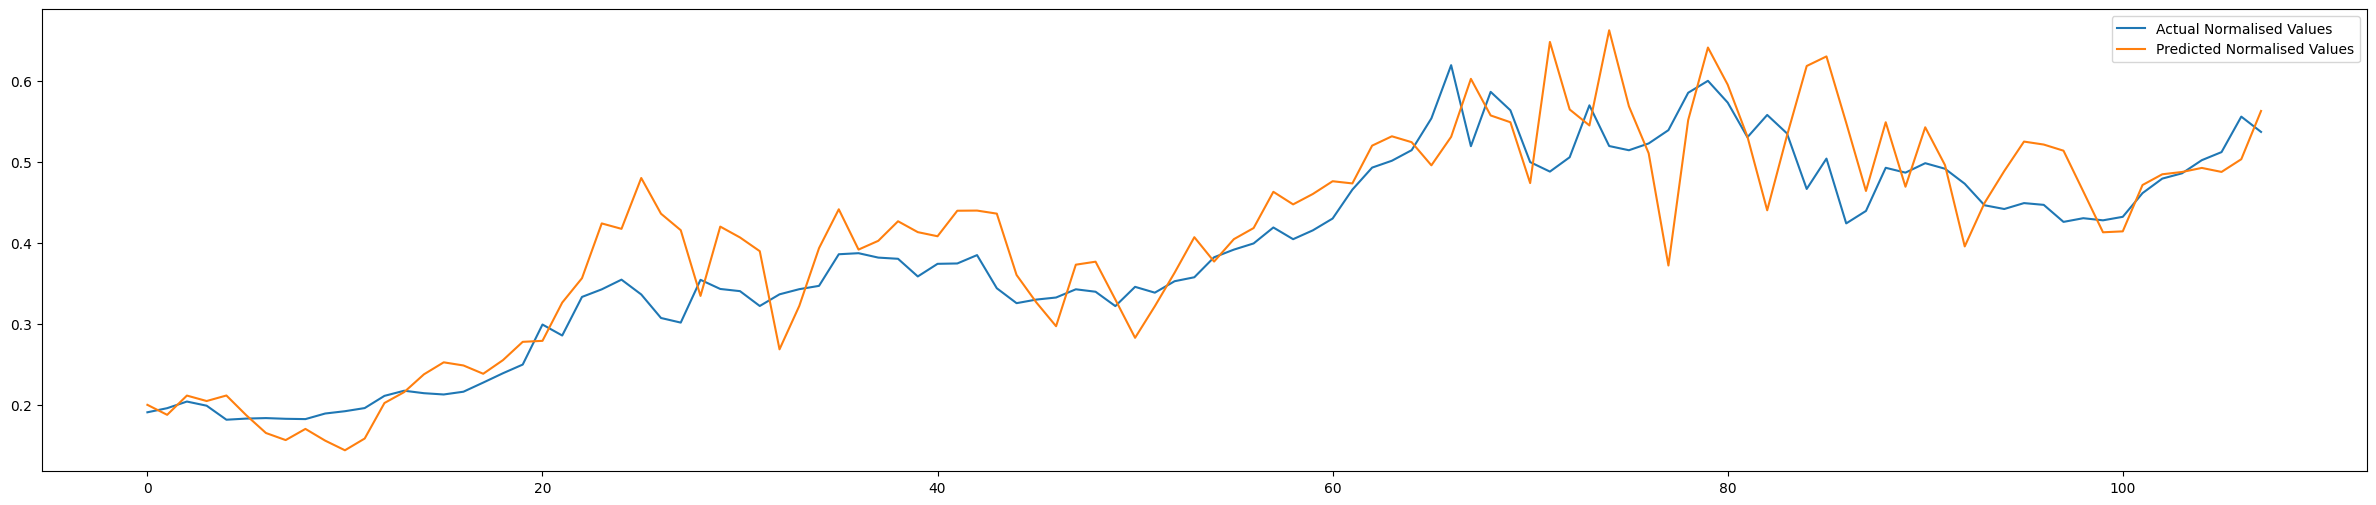

In [289]:
plt.figure(figsize=(30, 6))
plt.plot(test_y.reset_index()[9])
plt.plot(preds)
plt.legend(["Actual Normalised Values", "Predicted Normalised Values"])
plt.show()

In [291]:
d1 = (data1max - data1min + 2)[0]
print(type(d1))
denormalized_preds = (preds*d1)
# print(denormalized_preds)
denormalized_preds += (data1min + 1)[0]
# print(denormalized_preds)
preds1 = pd.DataFrame(denormalized_preds)
preds1['DATE'] = data1.index[-1*len(preds1):]
preds1 = preds1.set_index('DATE')
print(preds1)

<class 'numpy.float64'>
                       0
DATE                    
2019-04-22   5462.755322
2019-04-23   5243.893966
2019-04-24   5665.827085
2019-04-25   5546.413284
2019-04-26   5667.522415
...                  ...
2019-08-03  10564.393796
2019-08-04  10653.492677
2019-08-05  10565.783635
2019-08-06  10844.051982
2019-08-07  11901.057370

[108 rows x 1 columns]


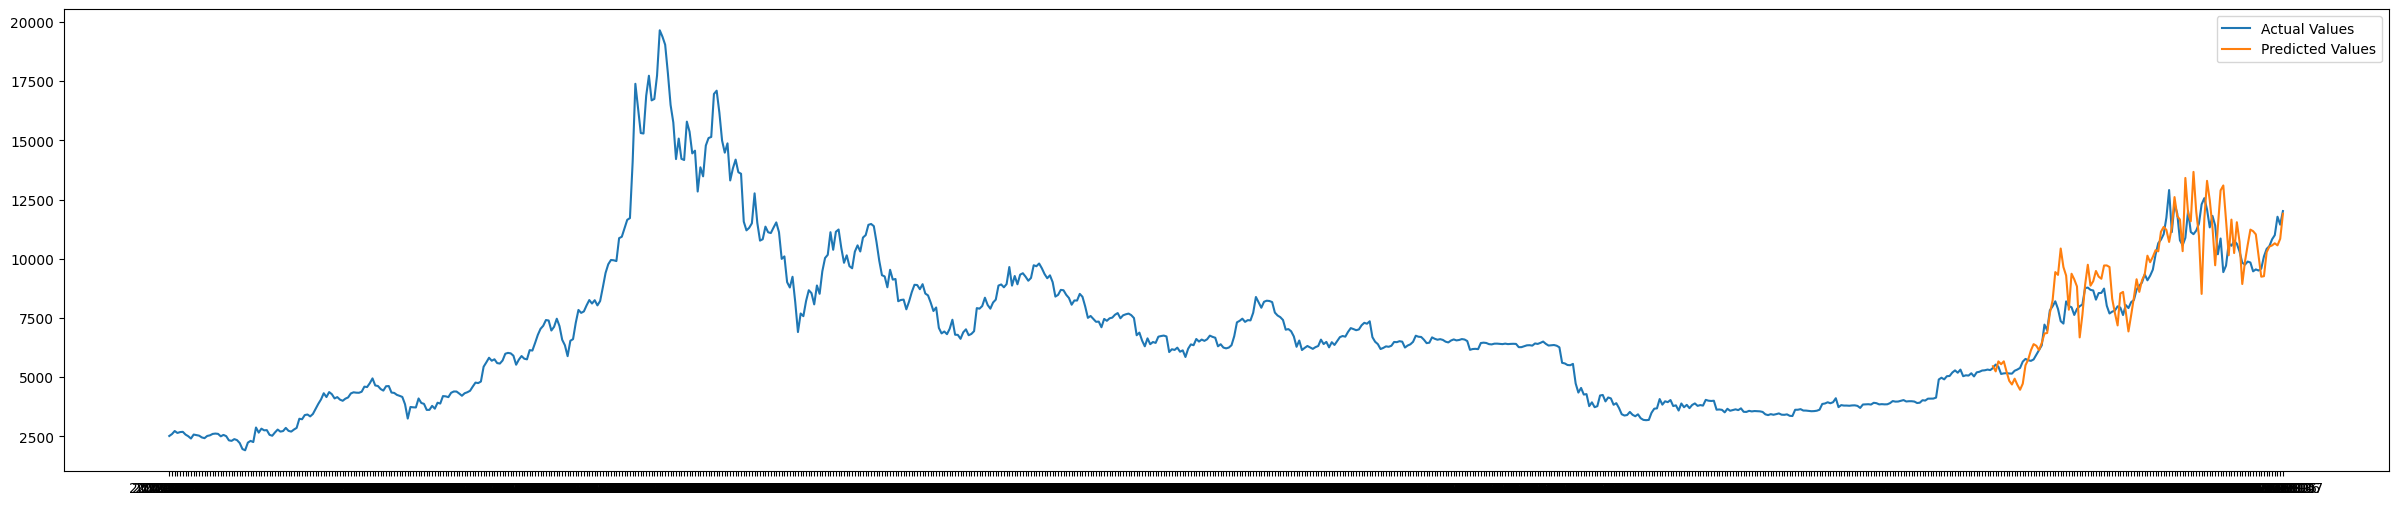

In [292]:
plt.figure(figsize=(30, 6))
plt.plot(data1)
plt.plot(preds1)
plt.legend(["Actual Values", "Predicted Values"])
plt.show()

In [293]:
mse = np.mean((np.array(preds1[0]) - np.array(data1.iloc[-1*(len(preds1)):, 0]))**2)
print("mse  "+ str(mse))
print("rmse "+ str(np.sqrt(mse)))

mse  1172298.748803288
rmse 1082.7274582291186
